# deepSSAM prototype notebook

This notebook contains a prototype implementation of a deepSSAM neural network algorithm that uses a pre-trained neural network to generalize gene expression information to FITC/DAPI technology information.

#### Imports:

In [19]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import os
# from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.neighbors import NearestNeighbors
import anndata


#### Parameter definition:

In [27]:
img_path_wall = '../../vizgen-merfish/vz-liver-showcase/Liver1Slice1/images/mosaic_Cellbound3_z4.tif'
img_path_dapi = '../../vizgen-merfish/vz-liver-showcase/Liver1Slice1/images/mosaic_DAPI_z4.tif'
coordinate_path = '../../vizgen-merfish/vz-liver-showcase/Liver1Slice1/detected_transcripts.csv'

scale=0.12 # scaling factor for images/coordinats. We want to end up with cell diameter ~30px (cellpose default)
model_type='cyto2' # cellpose model name. ['dapi','cyto','cyto2']

In [28]:
# SSAM vector field resolution:
um_per_pixel = 2.5

# SSAM pandwidth:
bw = 1

# KNN diffusion iterations to move spots to z-axis zero mean:
z_centralization_iters = 20

# {0:'xenium_mouse_brain',1:'merfish_mouse_brain',2:'merfish_liver'}
dataset =0

file_root = '/dh-projects/ag-ishaque/analysis/tiesmeys/spot-data-z-axis-incoherence/src'


In [35]:
# Load coordinate_path data frame, read only the columns
# global_x, global_y, global_z, fov	gene:

df = pd.read_csv(coordinate_path, sep=',', usecols=[2,3,4,8], header=0)[:10]

df.columns=['x','y','z','gene']

df.x-=df.x.min()
df.y-=df.y.min()
df.x/=um_per_pixel/scale
df.y/=um_per_pixel/scale


gene_counts = df.gene.value_counts()
genes = gene_counts.index

In [45]:
from src import ovrlp

roi_df = ovrlp.find_overlaps(df,min_distance=10)

roi_df

/dh-projects/ag-ishaque/analysis/tiesmeys/src/z-incoherence/src/ovrlp.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x_pixel'] = (df[xy_columns[0]] / grid_size).astype(int)
/dh-projects/ag-ishaque/analysis/tiesmeys/src/z-incoherence/src/ovrlp.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y_pixel'] = (df[xy_columns[1]] / grid_size).astype(int)
/dh-projects/ag-ishaque/analysis/tiesmeys/src/z-incoherence/src/ovrlp.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

,x,y,divergence
0,0,51,56.794255
1,0,246,74.559278
2,0,251,78.098126
3,0,260,73.452046
4,1,58,55.344284
...,...,...,...
2361,482,60,71.931525
2362,484,71,56.937437
2363,484,79,61.505797
2364,485,45,57.782608


In [50]:

ovrlp.visualize_rois(df,roi_df, signature_matrix = None,
                     celltyping_min_expression=5,
                     n_cases=[0,1],plot_window_size=20)

TypeError: visualize_rois() got an unexpected keyword argument 'signatures'

#### Loading image data:

In [ ]:

from PIL import Image

Image.MAX_IMAGE_PIXELS =10e10

img_=Image.open(img_path_wall)#[:4000,:4000]
img_=(np.array(img_.resize((np.array(img_.size)*scale).astype(int)),)[...,None]/256).astype("uint8")
print(img_.max())

img_ = np.concatenate((np.zeros_like(img_),img_, (np.array(Image.open(img_path_dapi).resize(img_.shape[1::-1]))[...,None]/256).astype("uint8")),axis=-1,dtype='uint8')
# img_ = img_[:2000,:2000]

img=img_.copy()
# img = np.array(img)

# del img_

plt.imshow(img_)

#### Apply spatial equalizer to the image. 

In [6]:

from scipy import ndimage

img=img_.copy()

# walls_hpf = np.fft.ifft2(ndimage.fourier_gaussian(np.fft.fft2(img_[:,:,1]), sigma=100)).real
# walls_hpf = img_[:,:,1]/(walls_hpf+0.1)
# walls_hpf=walls_hpf**0.8
# walls_hpf/=walls_hpf.max()/4000
# walls_hpf[walls_hpf>256]=255
# img[:,:,1]= (walls_hpf).astype("uint8")

# dapi_hpf = np.fft.ifft2(ndimage.fourier_gaussian(np.fft.fft2(img_[:,:,2]), sigma=100)).real
# dapi_hpf = img_[:,:,2]/(dapi_hpf+0.1)
# dapi_hpf = dapi_hpf**0.8
# dapi_hpf/=dapi_hpf.max()/3000
# dapi_hpf[dapi_hpf>256]=255
# img[:,:,2]= (dapi_hpf).astype("uint8")

img = img.transpose((1,0,2))

del img_

In [7]:
# img_val = img[img.shape[1]:,:img.shape[1]]
# img_train =  img[:img.shape[1],:img.shape[1]]

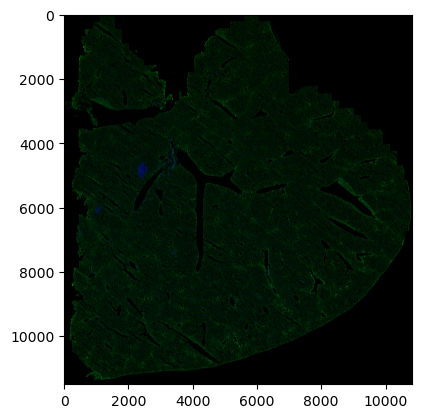

In [8]:
plt.figure()
plt.imshow(img)